# The Grand Poobah Classification Notebook
In this notebook we will cover uses of scikit-learn for many different purposes including:
- Cross Validation and metrics for scoring (including ROC and confusion matrices)
- Pipelines
- Common (nonlinear model) Classification:
 - K-Nearest Neighbors
 - Naive Bayes
 - Decision Trees
- Bagging (Random Forests)
- Boosting (Gradient of Error)
- Statistical Comparison Questions

We will look at some of the advanced features of scikit and look at many different ways of going about using the system to its fullest potential.

- http://en.wikipedia.org/wiki/Grand_Poobah

For this assignment we will use the LFW faces dataset and try to perform recognition of different individual's faces with several different classifiers. 

You can look up the dataset here:
 - http://vis-www.cs.umass.edu/lfw/

In [2]:
# fetch the images for the dataset
# this will take a long time the first run because it needs to download
# after the first time, the dataset will be save to your disk (in sklearn package somewhere) 
# if this does not run, you may need additional libraries installed on your system (you will need to figure out which ones!!)
from sklearn.datasets import fetch_lfw_people

# only load people that have N or more examples in the dataset
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.4) 

<class 'sklearn.datasets.base.Bunch'>
<type 'numpy.ndarray'>
[  58.           92.66666412  156.66667175 ...,   19.           17.66666603
   19.66666603]
('Size of the dataset:', (3023, 1850))
('Number of unique classes:', 62)
['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar' 'Juan Carlos Ferrero'
 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush' 'Lindsay Davenport'
 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva' 'Mahmoud Abbas'
 'Megawati Sukarnoputri' 'Michael

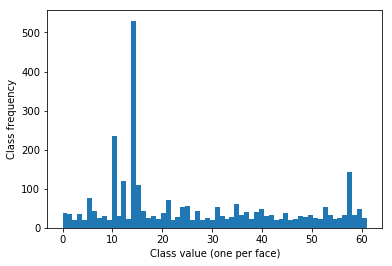

In [8]:
print type(lfw_people)
print type(lfw_people.data)
print lfw_people.data[0, :]


print ('Size of the dataset:', lfw_people.data.shape)
print ('Number of unique classes:', len(lfw_people.target_names))
print lfw_people.target_names
print lfw_people.target

from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(lfw_people.target, bins=len(lfw_people.target_names))
plt.xlabel('Class value (one per face)')
plt.ylabel('Class frequency')
plt.show()

In [4]:
print(np.min(lfw_people.data), np.max(lfw_people.data))
lfw_people.data[25]

(0.0, 255.0)


array([ 102.33333588,  133.66667175,  143.66667175, ...,  175.33332825,
        148.        ,   47.66666794], dtype=float32)

George W Bush


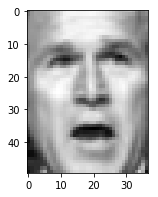

In [5]:
print(lfw_people.target_names[lfw_people.target[25]])
h = 50
w = 37
fig = plt.figure(figsize=(7,3))
plt.imshow(lfw_people.data[25].reshape((h, w)), 
           cmap=plt.cm.gray)
plt.grid(False)

# How should we choose training and testing splits??
- cross validation, how many folds?
- repeated holdout?
- stratified?

# Accuracy, precision, recall?
- How do you perform precision or recall when there are mutliple classes?

Recognizing faces is a classification procedure that we want to be accurate. **Detecting faces** might be something where we want low false positives (i.e., when we think there is a face, there should truly be one). Whereas we might be okay with more false negatives (i.e., we miss a few faces in the image). But this is **classification, not face detection**. Therefore, for this dataset it probably makes sense to be accurate overall--because we have many classes. However, we have such a class imbalance in this dataset that we also want to be aware of false positives and false negatives. 

Namely, an argument can be made for looking at false negatives/positives on a **per class basis**. For instance, an individual with lots of examples (i.e., a person with many examples in the dataset), we might prefer low false positives for that person. For a person with relatively few examples in the dataset we might prefer low false negatives (when we see an image of them, we identify them correctly). As such, we might breakup the dataset into different populations
- (1) those that occur frequently (prefer low false positives or high precision)
- (2) those that occur less frequently (prefer low false negatives or high recall)
- (3) the entire dataset (prefer high accuracy)
- (4) average accuracy per class (prefer everyone to have high true positive rate)
- (5) NOTE: that recall and precision are not always dealt with like this! You should look at the structure of your application to decide how to apply accuracy, precision, recall or whatever validation measure best defines your data.

Let's start with a simple classifier and ten fold cross validation, calculating accuracy to start.

In [11]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
from sklearn import linear_model

# create variables we are more familiar with
X = lfw_people.data
y = lfw_people.target
yhat = np.zeros(y.shape) # we will fill this with predictions

scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

# get a handle to the classifier object, which defines the type
#clf = KNeighborsClassifier(n_neighbors=3)
clf = linear_model.LogisticRegression()
# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('Logistic regression accuracy', total_accuracy)

('Logistic regression accuracy', 0.57790274561693677)
CPU times: user 45min 25s, sys: 10.9 s, total: 45min 36s
Wall time: 1h 49min 58s


Well, that was not highly accurate. Let's get the accuracy up before measuring other performance. One thing that might help is reducing the dimensionality of the faces like we have done before. however, instead of manually coding the PCA step and then classifying, let's train a PipeLine in sklearn.

A pipeline allows us to cascade operations. The pipeline can be setup to run PCA, then fit the reduced data with a classifier. The beauty of pipelines comes through when performing different cross validations.

In [9]:
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

# setup pipeline to take PCA, then fit a KNN classifier
clf_pipe = Pipeline(
    [('PCA_Eric',PCA(n_components=100,svd_solver='randomized')),
     ('CLF_Eric',KNeighborsClassifier(n_neighbors=1))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('KNN, pipeline accuracy', total_accuracy)

('KNN, pipeline accuracy', 0.36056897122064174)


In [17]:
# Added by Yuhang
# Now we compare the accuracies of the two approaches on 
# the same 10 folds to ensure an apples-to-apples comparison

from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

k_nn = 1

# setup pipeline to take PCA, then fit a KNN classifier
clf_pipe_knn_only = Pipeline(
    [('CLF',KNeighborsClassifier(n_neighbors=k_nn))]
)

# You can try a couple of different n_components values (such as 50, 100, 150, 200, 300, 400)
# and see how accuracy changes
clf_pipe_pca_knn = Pipeline(
    [('PCA',PCA(n_components=100,svd_solver='randomized')),
     ('CLF',KNeighborsClassifier(n_neighbors=k_nn))]
)

yhat_knn_only = np.zeros(y.shape) # we will fill this with predictions
yhat_pca_knn = np.zeros(y.shape) # we will fill this with predictions

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe_knn_only.fit(X[train],y[train])
    yhat_knn_only[test] = clf_pipe_knn_only.predict(X[test])
    clf_pipe_pca_knn.fit(X[train],y[train])
    yhat_pca_knn[test] = clf_pipe_pca_knn.predict(X[test])
    
total_accuracy_knn_only = mt.accuracy_score(y, yhat_knn_only)
print ('KNN only pipeline accuracy', total_accuracy_knn_only)
total_accuracy_pca_knn = mt.accuracy_score(y, yhat_pca_knn)
print ('PCA + KNN pipeline accuracy', total_accuracy_pca_knn)

('KNN only pipeline accuracy', 0.36850810453192195)
('PCA + KNN pipeline accuracy', 0.36056897122064174)


This is performing about the same overall. Lets take a look at the accuracy per class to get a better idea about how this is performing. To do this, we need to look at the confusion matrix. What classes are getting classified well?

Scikit-learn implements confusion matrices as follows: 

![Confusion Matirx](http://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_001.png)

('Average per class accuracy', 0.27668290764562786)


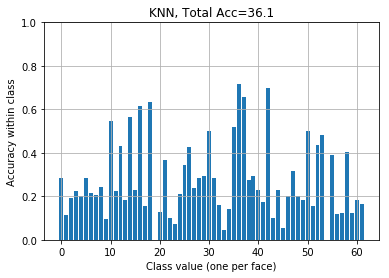

In [18]:
def per_class_accuracy(ytrue, yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue, yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    print('Average per class accuracy', np.mean(acc_list))
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
plot_class_acc(y, yhat_pca_knn, title="KNN")

We don't seem to be doing very well... Perhaps we should change the classifier we are using--why would this be the case?

('Pipeline accuracy', 0.34369831293417136)
('Average per class accuracy', 0.14125850732322998)


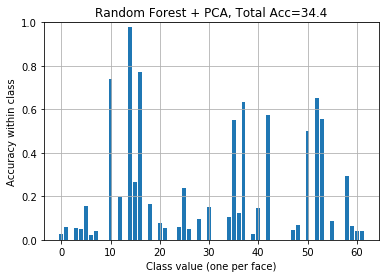

CPU times: user 4min 47s, sys: 16.9 s, total: 5min 4s
Wall time: 1min 20s


In [14]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_pipe = Pipeline(
    [('PCA',PCA(n_components=100, svd_solver='randomized')),
     ('CLF',RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1))
#     ('CLF',RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, class_weight='balanced'))
    ]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Pipeline accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest + PCA")

('Accuracy', 0.39431028779358251)
('Average per class accuracy', 0.24435243244747745)


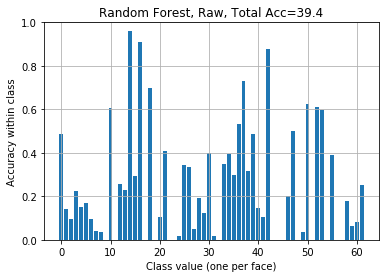

CPU times: user 18min 45s, sys: 25.1 s, total: 19min 10s
Wall time: 3min 55s


In [15]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True, class_weight='balanced')

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest, Raw")

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


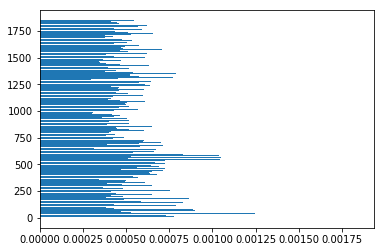

('Generalization score estimate from training data', 0.37053245805981033)


In [16]:
# now lets get access to the different properties of our RF

print (clf)

plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

print ('Generalization score estimate from training data', clf.oob_score_)

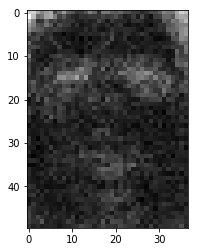

In [17]:
h = 50
w = 37
plt.imshow(clf.feature_importances_.reshape((h, w)), cmap=plt.cm.gray)
plt.grid(False)
plt.show()

# Tree Ensemble Comparisons

In [36]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

num_estimators = 50
# lets train some trees
clf_array = [
    ('Stump',              DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)),
    ('Tree',               DecisionTreeClassifier()),
    ('Random Trees',       RandomForestClassifier(max_depth=50, n_estimators=num_estimators)),
    ('Extra Random Trees', ExtraTreesClassifier(n_estimators=num_estimators,min_samples_split=2))
#    ('Boosted Tree',       GradientBoostingClassifier(n_estimators=num_estimators)), #takes a long time
    ]

for clf in clf_array:
    acc = cross_val_score(clf[1],X,y)
    print (clf[0], acc.mean())

('Stump', 0.17439067391711846)
('Tree', 0.17660129032865327)
('Random Trees', 0.35415762965916803)
('Extra Random Trees', 0.37801960942710483)
CPU times: user 39.7 s, sys: 516 ms, total: 40.2 s
Wall time: 40.4 s


('Pipeline accuracy', 0.54713860403572612)
('Average per class accuracy', 0.44979910936326967)


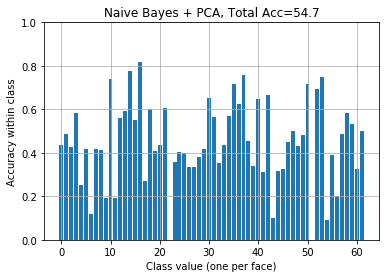

In [25]:
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',PCA(n_components=100,svd_solver='randomized')),
     ('CLF',GaussianNB())
    ])

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('Pipeline accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Naive Bayes + PCA")

('Using', 10, 'PCs')
('Using', 20, 'PCs')
('Using', 30, 'PCs')
('Using', 40, 'PCs')
('Using', 50, 'PCs')
('Using', 60, 'PCs')
('Using', 70, 'PCs')
('Using', 80, 'PCs')
('Using', 90, 'PCs')
('Using', 100, 'PCs')
('Using', 110, 'PCs')
('Using', 120, 'PCs')
('Using', 130, 'PCs')
('Using', 140, 'PCs')
('Using', 150, 'PCs')
('Using', 160, 'PCs')
('Using', 170, 'PCs')
('Using', 180, 'PCs')
('Using', 190, 'PCs')
('Using', 200, 'PCs')


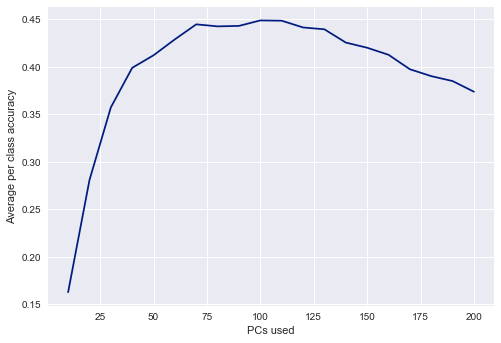

In [61]:
from sklearn.naive_bayes import GaussianNB

pcs = range(10, 210, 10)
accuracies = []

for n in pcs:
    print('Using', n, 'PCs')
    # setup pipeline to take PCA, then fit a different classifier
    clf_pipe = Pipeline(
        [('PCA',PCA(n_components=n,svd_solver='randomized')),
         ('CLF',GaussianNB())]
    )

    # now iterate through and get predictions, saved to the correct row in yhat
    for train, test in cv.split(X,y):
        clf_pipe.fit(X[train],y[train])
        yhat[test] = clf_pipe.predict(X[test])

    acc_list = per_class_accuracy(y,yhat)
    accuracies.append(np.mean(acc_list))

plt.plot(pcs, accuracies)
plt.xlabel('PCs used')
plt.ylabel('Average per class accuracy')


In [41]:
from sklearn import metrics as mt

freq_infreq_threshold = 40

# get various measures of performance
total_accuracy = mt.accuracy_score(y, yhat)
per_class_acc_list = per_class_accuracy(y,yhat)

prec_for_freq_classes = []
recall_for_infreq_classes = []
rec_tot = []
prec_tot = []

for cls in np.unique(y):
    idx = (y==cls) # get classes
    ytmp_actual = np.zeros(y.shape) # make binary class problem
    ytmp_actual[idx] = 1 # set the instances for this specific class
    
    ytmp_predicted = np.zeros(y.shape) # binary prediction array
    ytmp_predicted[yhat==cls] = 1
    
    num_in_class = sum(idx)
    
    rec = mt.recall_score(ytmp_actual, ytmp_predicted)
    prec = mt.precision_score(ytmp_actual, ytmp_predicted)
    rec_tot.append(rec)
    prec_tot.append(prec)
    
    if num_in_class < freq_infreq_threshold:
        recall_for_infreq_classes.append(rec)
    elif num_in_class >= freq_infreq_threshold:
        prec_for_freq_classes.append(prec)
        
print ('Total Accuracy:',total_accuracy)
print ('Number of infrequent faces:',len(recall_for_infreq_classes), 
       'with average recall of:', np.mean(recall_for_infreq_classes))
print ('Number of frequent faces:',len(prec_for_freq_classes), 
       'with average precision of:',np.mean(prec_for_freq_classes))

('Total Accuracy:', 0.49520344029110158)
('Number of infrequent faces:', 43, 'with average recall of:', 0.32281099615120057)
('Number of frequent faces:', 19, 'with average precision of:', 0.5083167966957598)


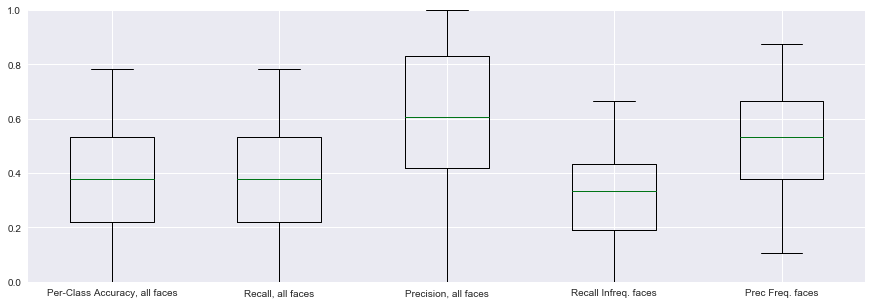

In [43]:
# But we can really summarize this data much better than this. 
# How about looking at more statistics of the precision and recall for each class?

import seaborn as sns
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.boxplot([per_class_acc_list, rec_tot, prec_tot, recall_for_infreq_classes,prec_for_freq_classes],
            labels=['Per-Class Accuracy, all faces', 'Recall, all faces','Precision, all faces','Recall Infreq. faces','Prec Freq. faces'])
plt.ylim([0,1])
plt.show()

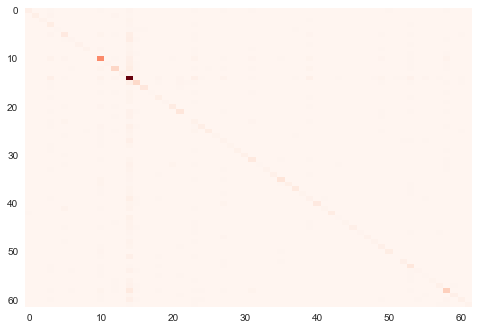

In [44]:
# how about plotting a confusion matrix?
cm = mt.confusion_matrix(y, yhat)
plt.imshow(cm,cmap=plt.get_cmap('Reds'),aspect='auto')
plt.grid(False)

# What is the problem with this graph??

In [88]:
# %load -r 32-34 statcompare.py


In [66]:
from sklearn.naive_bayes import GaussianNB


# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',PCA(n_components=100,svd_solver='randomized')),
     ('CLF',GaussianNB())]
)

yhat_score = np.zeros((y.shape[0],len(lfw_people.target_names)))

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])
    yhat_score[test] = clf_pipe.predict_proba(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('Pipeline accuracy', total_accuracy)

('Pipeline accuracy', 0.5464770095931194)


## Using the ROC Curve
In the below example we can see how to graph the false negatives and false positives in an ROC curve for a given classifier. Please note that the "scores" from the classifier have already been populated using the code above. The scores can be interpretted as the the probability that a given class should be designated as positive. These scores are needed so that the ROC can change thresholds deciding if theclass is positive or negative. Once we have the scores, we can send each column of scores (i.e., the probability for that class being positive) into the ROC curve generator and it will give use the arrays of false positives and negatives for that class as the threshold is increased. 

We save the outputs into a dictionary of fpr and tpr (false positive and true positive rates). The keys to the dictionary are the class value. We can also compute the ROC treshold for all the classes by placing their probabilities into one giant vector and whether they should or should not be a value of one. Please note that this method of combining all classes into a single ROC is not considered a standard method--it has limited utility outside classifier comparison. If you understand the limitations it can be an effective tool. If not, then I would not recommend using it to compare models right away. 

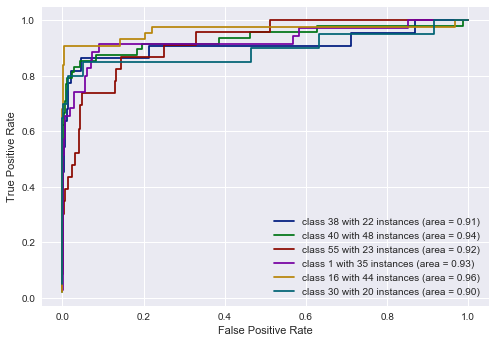

In [67]:
import seaborn as sns
sns.set_palette("dark")
# code manipulated from http://scikit-learn.org/stable/auto_examples/plot_roc.html
from sklearn.preprocessing import label_binarize

# Compute ROC curve for a subset of interesting classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in np.unique(y):
    fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
    roc_auc[i] = mt.auc(fpr[i], tpr[i])

for i in np.random.permutation(60)[0:6]:
    plt.plot(fpr[i], tpr[i], label='class {0} with {1} instances (area = {2:0.2f})'
                                   ''.format(i, sum(y==i), roc_auc[i]))

plt.legend(loc="lower right")  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

(187426,)
[[  3.31892867e-12   9.91842465e-01   6.97736135e-12 ...,   1.21415271e-14
    6.09360816e-05   5.13934073e-04]
 [  1.13847997e-03   2.20606148e-06   1.48807019e-07 ...,   2.51650573e-04
    3.20480886e-02   1.87121398e-08]
 [  8.95039695e-03   2.92180179e-07   1.57288676e-06 ...,   3.84121294e-05
    1.41413823e-04   3.78643519e-05]
 ..., 
 [  2.55071251e-03   1.42934934e-06   2.42560594e-07 ...,   1.51062776e-07
    3.58332616e-06   5.42936478e-12]
 [  3.99828911e-07   1.03964667e-07   1.29601014e-11 ...,   1.31291647e-07
    6.43366319e-07   1.02640049e-11]
 [  1.08938781e-05   4.86343392e-09   1.26281801e-08 ...,   1.19129077e-08
    1.06433601e-05   2.91157415e-13]]


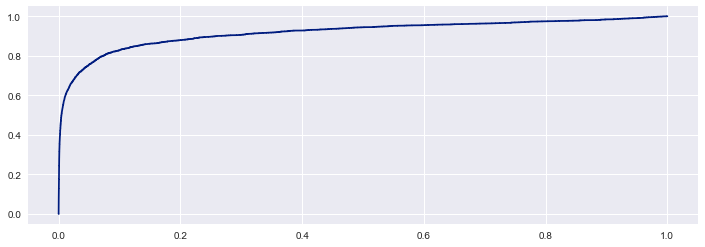

In [76]:
# combined ROC over all classes
one_hot_class_encoding = label_binarize(y,np.unique(y))
#print(one_hot_class_encoding)
print(one_hot_class_encoding.ravel().shape)
print(yhat_score)
fpr["micro"], tpr["micro"], _ = mt.roc_curve(one_hot_class_encoding.ravel(), yhat_score.ravel())
roc_auc["micro"] = mt.auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12,4))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

# Statistical Comparison 
- how might you compare two classifiers trained on the exact same datasets?

Note: if these cells are not loaded, you might need to run the `%load ` magic.

In [84]:
# %load -r 1-15 statcompare.py


In [87]:
# %load -r 19-28 statcompare.py


Epoch 1/25
2689/2689 [==============================] - 39s - loss: 3.8120 - acc: 0.1696    
Epoch 2/25
2689/2689 [==============================] - 38s - loss: 3.5767 - acc: 0.1986    
Epoch 3/25
2689/2689 [==============================] - 37s - loss: 3.3647 - acc: 0.2164    
Epoch 4/25
2689/2689 [==============================] - 38s - loss: 3.1779 - acc: 0.2581    
Epoch 5/25
2689/2689 [==============================] - 38s - loss: 2.8775 - acc: 0.3057    
Epoch 6/25
2689/2689 [==============================] - 38s - loss: 2.6883 - acc: 0.3518    
Epoch 7/25
2689/2689 [==============================] - 38s - loss: 2.5019 - acc: 0.3912    
Epoch 8/25
2689/2689 [==============================] - 38s - loss: 2.3392 - acc: 0.4187    
Epoch 9/25
2689/2689 [==============================] - 38s - loss: 2.1734 - acc: 0.4619    
Epoch 10/25
2689/2689 [==============================] - 38s - loss: 2.0446 - acc: 0.4820    
Epoch 11/25
2689/2689 [==============================] - 39s - loss: 

2730/2730 [==============================] - 39s - loss: 0.5060 - acc: 0.8473    
Epoch 22/25
2730/2730 [==============================] - 38s - loss: 0.4792 - acc: 0.8498    
Epoch 23/25
2730/2730 [==============================] - 38s - loss: 0.4392 - acc: 0.8641    
Epoch 24/25
2730/2730 [==============================] - 38s - loss: 0.4078 - acc: 0.8751    
Epoch 25/25
2733/2733 [==============================] - 40s - loss: 3.8409 - acc: 0.1709    
Epoch 2/25
2733/2733 [==============================] - 39s - loss: 3.6028 - acc: 0.1976    
Epoch 3/25
2733/2733 [==============================] - 39s - loss: 3.3050 - acc: 0.2382    
Epoch 4/25
2733/2733 [==============================] - 38s - loss: 3.0943 - acc: 0.2821    
Epoch 5/25
2733/2733 [==============================] - 38s - loss: 2.8126 - acc: 0.3282    
Epoch 6/25
2733/2733 [==============================] - 39s - loss: 2.5656 - acc: 0.3802    
Epoch 7/25
2733/2733 [==============================] - 39s - loss: 2.2869 - 

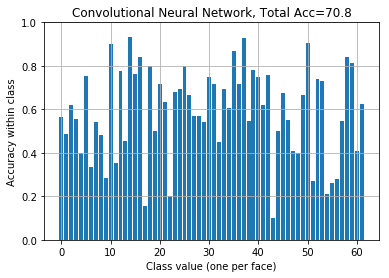

In [28]:
# Added by Yuhang Wang
# Using deep neural net to classify faces
# To run this code, you will need to install keras first
# https://anaconda.org/conda-forge/keras
# I used Keras with tensorflow backend. For more info about Keras, see
# https://keras.io/getting-started/sequential-model-guide/

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.constraints import maxnorm

# input image dimensions
img_rows, img_cols = 50, 37
num_classes = 62
batch_size = 128
epochs = 25

# input: 50x37 images with 1 channel -> (50, 37, 1) tensors.
input_shape = (img_rows, img_cols, 1)

cv = StratifiedKFold(n_splits=10)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
yhat = np.zeros(y.shape) # we will fill this with predictions

for train, test in cv.split(X,y):
    x_train = X[train].reshape(X[train].shape[0], img_rows, img_cols, 1)
    y_train = keras.utils.to_categorical(y[train], num_classes=num_classes)
    x_test = X[test].reshape(X[test].shape[0], img_rows, img_cols, 1)
    y_test = keras.utils.to_categorical(y[test], num_classes=num_classes)

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
    yhat[test] = model.predict_classes(x_test)

total_accuracy = mt.accuracy_score(y, yhat)
print ('Total accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Convolutional Neural Network")